# PU learning techniques applied to artificial data

## "Blobs" data set

In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.datasets.samples_generator import make_blobs, make_circles
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from baggingPU import BaggingClassifierPU
from pu_learning import spies
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.ERROR)
logging.debug("Initiating logger...")
plt.rcParams['figure.figsize'] = 9, 7
plt.rcParams['font.size'] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data for example 1. Skip executioin of next cell if you want to use blobs.

In [39]:
# Create the data set BLOBS
X, y = make_blobs(
    n_samples = 6000, 
    centers = [[1,5], [5,1], [0,0], [6,6]]
)
y = (y > 1).astype(int)  # Convert the original labels [0,1,2,3] to [0,1]

Data for example 2.

In [40]:
# # Create the data set CIRCLES
# X, y = make_circles(
#     n_samples = 6000, noise = 0.1, 
#     shuffle = True, factor = .65
# )

6000 data points and 2 features
3000 positive out of 6000 total
300 positive out of 6000 total


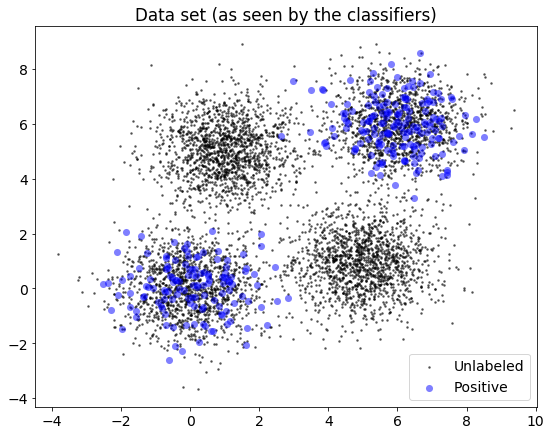

In [41]:
X = pd.DataFrame(X, columns = ['feature1', 'feature2'])
y = pd.Series(y)

# Check the contents of the set
print('%d data points and %d features' % (X.shape))
print('%d positive out of %d total' % (sum(y), len(y)))

# Keep the original targets safe for later
y_orig = y.copy()

# Unlabel a certain number of data points
hidden_size = 2700
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

# Check the new contents of the set
print('%d positive out of %d total' % (sum(y), len(y)))

# Plot the data set, as the models will see it
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Unlabeled'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (as seen by the classifiers)')
plt.show()

## Standard classifier

In [42]:
%%time

rf = RandomForestClassifier(
    n_estimators = 1000,  # Use 1000 trees
    n_jobs = -1           # Use all CPU cores
)
rf.fit(X, y)

# Store the scores assigned by this approach
results = pd.DataFrame({
    'truth'      : y_orig,   # The true labels
    'label'      : y,        # The labels to be shown to models in experiment
    'output_std' : rf.predict_proba(X)[:,1]   # The random forest's scores
}, columns = ['truth', 'label', 'output_std'])

CPU times: user 8.81 s, sys: 459 ms, total: 9.27 s
Wall time: 2.4 s


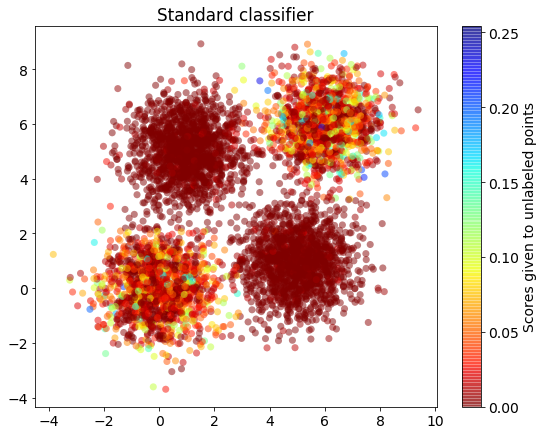

In [43]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_std, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Standard classifier')
plt.show()

## Bagging with DecisionTreeClassifier

In [44]:
%%time

bc = BaggingClassifierPU(
    DecisionTreeClassifier(),
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)
results['output_bag_tree'] = bc.oob_decision_function_[:,1]

CPU times: user 2.28 s, sys: 6.58 ms, total: 2.29 s
Wall time: 3.79 s


/home/trokas/Dropbox/data/Projects/pu_learning/baggingPU.py:593: RuntimeWarning: divide by zero encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


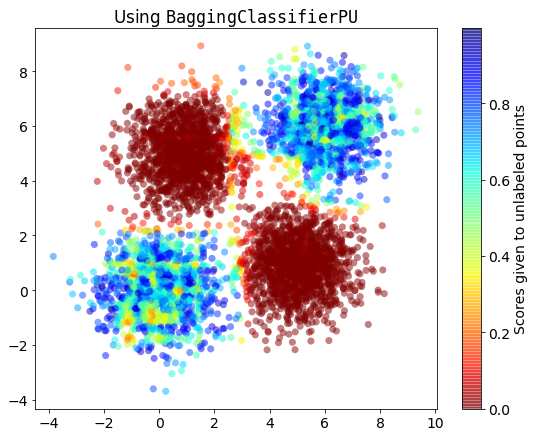

In [45]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_bag_tree, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt BaggingClassifierPU}$')
plt.show()

## Bagging with SVC

In [46]:
%%time

bc = BaggingClassifierPU(
    SVC(),
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)
results['output_bag_svc'] = bc.oob_decision_function_[:,1]

CPU times: user 42.5 s, sys: 0 ns, total: 42.5 s
Wall time: 46 s


/home/trokas/Dropbox/data/Projects/pu_learning/baggingPU.py:593: RuntimeWarning: divide by zero encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


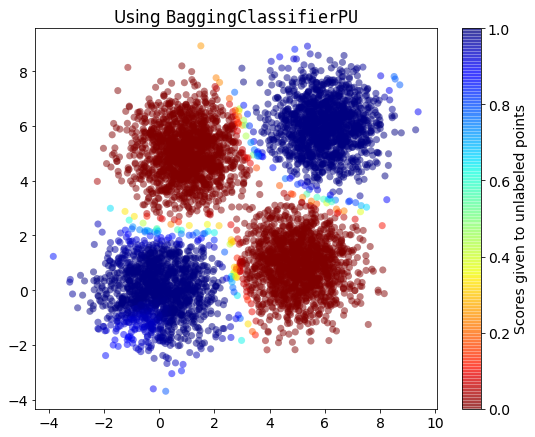

In [47]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_bag_svc, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt BaggingClassifierPU}$')
plt.show()

# Spies

In [48]:
%%time

model = spies(XGBClassifier(), XGBClassifier())
model.fit(X, y)
results['output_spies'] = model.predict_proba(X)
print('Accuracy - {0:.01%}, AUC - {1:.04}'.format((model.predict(X) == y_orig).mean(), roc_auc_score(y_orig, results['output_spies'])))

Accuracy - 96.8%, AUC - 0.9946
CPU times: user 241 ms, sys: 7 µs, total: 241 ms
Wall time: 240 ms


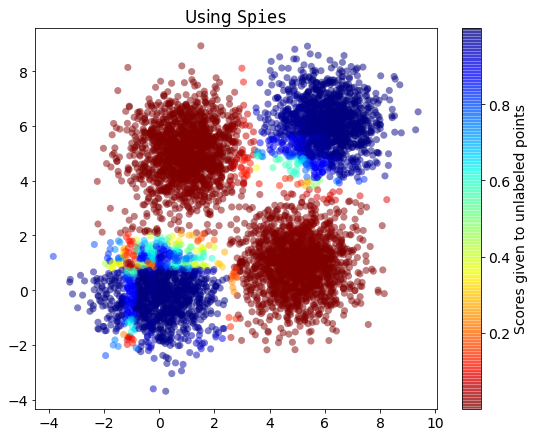

In [49]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_spies, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt Spies}$')
plt.show()

## Comparison of approaches

In [50]:
# Prepare for graphing the performance 
# (i.e. the success in identifying hidden positives)
ts = range(100, hidden_size, 100)
y_std, y_bag_tree, y_bag_svc, y_spies = [], [], [], []
for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )
    y_bag_tree.append(
        results[results.label == 0].sort_values(
            'output_bag_tree', ascending = False
        ).head(t).truth.mean()
    )
    y_bag_svc.append(
        results[results.label == 0].sort_values(
            'output_bag_svc', ascending = False
        ).head(t).truth.mean()
    )
    y_spies.append(
        results[results.label == 0].sort_values(
            'output_spies', ascending = False
        ).head(t).truth.mean()
    )

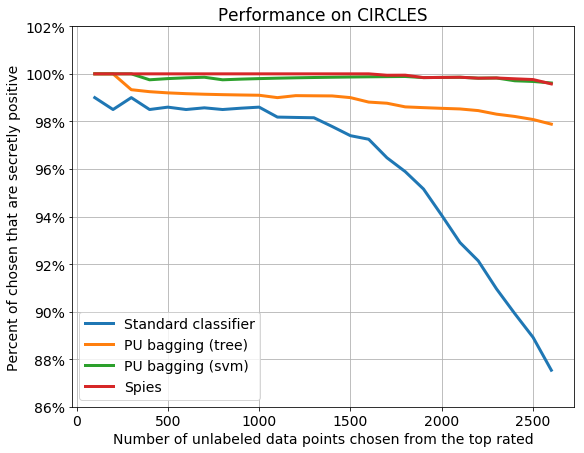

In [51]:
# Performance graphing
plt.plot(
    ts, y_std,
    ts, y_bag_tree,
    ts, y_bag_svc,
    ts, y_spies,
    lw = 3
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly positive')
plt.legend([
    'Standard classifier', 
    'PU bagging (tree)',
    'PU bagging (svm)',
    'Spies'
])
ylim = plt.gca().get_ylim()
plt.title('Performance on CIRCLES')
plt.grid()
plt.show()